## General functions

In [1]:
import glob
import itertools
import math
import os
import random
import shutil
import statistics
import sys
from pathlib import Path

import fiona
import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
from shapely.geometry import Point, Polygon, mapping
from tqdm import tqdm

c:\Users\ycao68\AppData\Local\miniconda3\Lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

### generate N random polygons inside the polygons and distances far than 50 from boundary

In [3]:
def create_points(polygon, number, distance=50):
    # Empty list for points
    points = []

    # Get polygon bounds
    min_x, min_y, max_x, max_y = polygon.bounds

    for i in range(0, 100):
        if len(points) < number:
            # Create random point
            point = Point(random.uniform(min_x, max_x), random.uniform(min_y, max_y))
            point = point.buffer(11.28)  # buffer point returns a circle polygonal result

            # Plot criteria
            if polygon.contains(point):  # polygon must contain point
                if (
                    polygon.boundary.distance(point.boundary) >= distance
                ):  # 100m from boundary
                    points.append(point)  # append points if criteria met
        else:
            pass

    return points

In [16]:
def random_plots(boundary, n, distance=50):
    # Get crs
    crs = boundary.crs

    # Run random points
    all_points = []
    for i in range(0, len(boundary)):
        # print(f"{i} / {len(boundary)}")
        points = create_points(boundary.iloc[i].geometry, n, distance)
        if len(points) >= 1:
            points_gdf = gpd.GeoDataFrame({"geometry": points})
            all_points.append(points_gdf)

    # Create geodataframe of points
    if len(all_points) >= 1:
        plots = gpd.GeoDataFrame(pd.concat(all_points, ignore_index=True))
        plots.set_crs(crs=crs, inplace=True)  # set crs

        return plots

    else:
        return None

### get specs_percentage

In [10]:
def get_perc_specs(plots, start_col, end_col):
    # Subset plots with only species columns
    plots_spec = plots.iloc[:, start_col:end_col+1]

    # Get only valid species
    spec_tot = plots_spec.sum()  # sum each species
    spec_tot = spec_tot[spec_tot != 0.0]  # only keep values not equal to 0
    specs = list(spec_tot.index.values)  # list values
    plots_spec = plots_spec[specs]  # subset only valid columns

    # Create perc_specs
    perc_specs = plots_spec.iloc[:].values.tolist()  # create list of values
    perc_specs = [
        [x / 100 for x in i] for i in perc_specs
    ]  # divide by 100 to get percentage as decimal
    plots_df = pd.DataFrame(plots)
    plots_df["perc_specs"] = perc_specs  # add perc_specs column to plots

    return (plots_df, specs)

In [11]:
def remove_plots(plots, specs, n):
    plots_subset = plots[specs]  # subset plots to only relevant columns
    for column_name in plots_subset.columns:  # for each colum
        column = plots_subset[column_name]
        counts = column[column != 0].count()  # count non zero values
        if counts < n:  # if counts are less than 100
            plots = plots[plots[column_name] == 0]  # remove rows

    return plots

### sampling point clouds

In [10]:
def read_las(pointcloudfile, get_attributes=False, useevery=1):
    """
    :param pointcloudfile: specification of input file (format: las or laz)
    :param get_attributes: if True, will return all attributes in file, otherwise will only return XYZ (default is False)
    :param useevery: value specifies every n-th point to use from input, i.e. simple subsampling (default is 1, i.e. returning every point)
    :return: 3D array of points (x,y,z) of length number of points in input file (or subsampled by 'useevery')
    """

    # Read file
    inFile = laspy.read(pointcloudfile)

    # Get coordinates (XYZ)
    coords = np.vstack((inFile.x, inFile.y, inFile.z)).transpose()
    coords = coords[::useevery, :]

    # Return coordinates only
    if get_attributes == False:
        return coords

    # Return coordinates and attributes
    else:
        las_fields = [info.name for info in inFile.points.point_format.dimensions]
        attributes = {}
        # for las_field in las_fields[3:]:  # skip the X,Y,Z fields
        for las_field in las_fields:  # get all fields
            attributes[las_field] = inFile.points[las_field][::useevery]
        return (coords, attributes)

In [1]:
from pyproj import CRS

# Function to process and sample points within a polygon
def sample_points_within_polygon(las_file_path, polygon, output_folder, polyid, crs, get_attributes=False):
    extracted_points = []
    # Read the LAS file
    inFile = laspy.read(las_file_path)

    # crs_pyproj = CRS.from_user_input(crs)
    # inFile.header.add_crs(crs_pyproj)
    
    # Get bounds of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Get coordinates (XYZ)
    points = np.vstack((inFile.x, inFile.y, inFile.z)).transpose()

    # Apply the height filter to keep points with z > 2 meters
    height_filtered_points = points[points[:, 2] > 2]

    # Filter points within the bounds
    mask = (height_filtered_points[:, 0] >= minx) & (height_filtered_points[:, 0] <= maxx) & (height_filtered_points[:, 1] >= miny) & (height_filtered_points[:, 1] <= maxy)
    candidate_points = height_filtered_points[mask]

    # Further filter points within the polygon
    for point in candidate_points:
        if polygon.contains(Point(point[0], point[1])):
            extracted_points.append(point)
    extracted_points = np.array(extracted_points)

    if len(extracted_points) > 8000:
        output_las_file_path = os.path.join(output_folder, f"{polyid}.laz")
        
        # Save the merged points to a new LAS file
        output_las = laspy.create(point_format=inFile.header.point_format, file_version=inFile.header.version)
        output_las.x = extracted_points[:, 0]
        output_las.y = extracted_points[:, 1]
        output_las.z = extracted_points[:, 2]
        # Copy over other point attributes if needed (intensity, classification, etc.)
        if get_attributes:
            for dim in inFile.point_format.extra_dimensions:
                output_las[dim.name] = inFile[dim.name][extracted_points.index]

        output_las.write(output_las_file_path)
        print(f"Saved sampled points for {polyid} to {output_las_file_path}")
    else:
        print(f"Sampled points for {polyid} less than 8000")

In [2]:
def sample_pts(polygons_file_path, las_files_directory, output_folder):
    # Directory containing the LAS files
    las_files_directory = Path(las_files_directory)
    output_folder = Path(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    # Load the polygon GeoDataFrame
    gdf_polygons = gpd.read_file(Path(polygons_file_path))
    poly_crs=gdf_polygons.crs
    # Iterate through each polygon and process the corresponding LAS file
    for _, polygon_row in gdf_polygons.iterrows():
        poly_id = polygon_row['POLYID']
        tilename = polygon_row['Tilename']
        polygon = polygon_row.geometry
        
        # Find the corresponding LAS file
        las_file_path = os.path.join(las_files_directory, f"{tilename}.laz")
        if os.path.exists(las_file_path):
            sample_points_within_polygon(las_file_path, polygon, output_folder, poly_id, poly_crs)
        else:
            print(f"LAS file for {tilename} not found.")

In [ ]:
import pdal
import json
import os

def convert_crs(pts_dir, crs, out_dir):
    # supported / desirable extensions
    extensions = ['.laz'] # edit it to support more pc types
    # listing all files from the provided dir
    files = os.listdir(pts_dir)
    crs_pyproj = CRS.from_user_input(crs)
    for file in files:
        if not any(x in file for x in extensions): continue # if files with wrong extensions (rather silly check though it would work in simple cases)
        p = os.path.abspath(file) # get files abs path
        op = r"%s/%s" % (out_dir, file)
        jsonString = '{"pipeline": ["%s",{"type": "filters.reprojection","out_srs": "%s"},{"type":"writers.las","filename":"%s"}]}' % (p, crs_pyproj, op)  # json pipeline command
        # print(jsonString) 
        pipeline = pdal.Pipeline(jsonString) # create pdal pipeline
        pipeline.validate() # check if our JSON and options were good
        pipeline.execute() # run pdal pipeline execution    
        print("Processed: ", p) # print the result

In [11]:
def move_files(file, out_folder):
    if not os.path.exists(out_folder):
        os.makedirs(out_folder)
    filename = str(file).split("\\")[-1]
    outfile = os.path.join(out_folder, filename)
    shutil.move(file, outfile)

In [ ]:
def farthest_point_sampling(coords, k):
    # Adapted from https://minibatchai.com/sampling/2021/08/07/FPS.html

    # Get points into numpy array
    points = np.array(coords)

    # Get points index values
    idx = np.arange(len(coords))

    # Initialize use_idx
    use_idx = np.zeros(k, dtype="int")

    # Initialize dists
    dists = np.ones_like(idx) * float("inf")

    # Select a point from its index
    selected = 0
    use_idx[0] = idx[selected]

    # Delete Selected
    idx = np.delete(idx, selected)

    # Iteratively select points for a maximum of k samples
    for i in range(1, k):
        # Find distance to last added point and all others
        last_added = use_idx[i - 1]  # get last added point
        dist_to_last_added_point = ((points[last_added] - points[idx]) ** 2).sum(-1)

        # Update dists
        dists[idx] = np.minimum(dist_to_last_added_point, dists[idx])

        # Select point with largest distance
        selected = np.argmax(dists[idx])
        use_idx[i] = idx[selected]

        # Update idx
        idx = np.delete(idx, selected)
    return use_idx

In [ ]:
def write_las(outpoints, outfilepath, attribute_dict={}):
    """
    :param outpoints: 3D array of points to be written to output file
    :param outfilepath: specification of output file (format: las or laz)
    :param attribute_dict: dictionary of attributes (key: name of attribute; value: 1D array of attribute values in order of points in 'outpoints'); if not specified, dictionary is empty and nothing is added
    :return: None
    """
    import laspy

    hdr = laspy.LasHeader(version="1.4", point_format=6)
    hdr.x_scale = 0.00025
    hdr.y_scale = 0.00025
    hdr.z_scale = 0.00025
    mean_extent = np.mean(outpoints, axis=0)
    hdr.x_offset = int(mean_extent[0])
    hdr.y_offset = int(mean_extent[1])
    hdr.z_offset = int(mean_extent[2])

    las = laspy.LasData(hdr)

    las.x = outpoints[:, 0]
    las.y = outpoints[:, 1]
    las.z = outpoints[:, 2]
    for key, vals in attribute_dict.items():
        try:
            las[key] = vals
        except:
            las.add_extra_dim(laspy.ExtraBytesParams(name=key, type=type(vals[0])))
            las[key] = vals

    las.write(outfilepath)

In [ ]:
def resample_point_clouds(root_dir, train_dataset_path, max_points_list, samp_meth, glob="*.laz", bins=None):
    # Create training set for each point density
    files = list(Path(root_dir).glob(glob))

    for max_points in tqdm(max_points_list, desc="Total: ", leave=False, colour="blue"):
        # Make folders
        if not os.path.exists(os.path.join(train_dataset_path, "trainingsets")):
            os.makedirs(os.path.join(train_dataset_path, "trainingsets"))
        if not os.path.exists(
            os.path.join(train_dataset_path, "trainingsets", samp_meth)
        ):
            os.makedirs(os.path.join(train_dataset_path, "trainingsets", samp_meth))
        if not os.path.exists(
            os.path.join(train_dataset_path, "trainingsets", samp_meth, str(max_points))
        ):
            os.makedirs(
                os.path.join(
                    train_dataset_path, "trainingsets", samp_meth, str(max_points)
                )
            )

        for file in tqdm(
            files, desc="Max Points: " + str(max_points), leave=False, colour="red"
        ):
            # Read las/laz file
            coords, attrs = read_las(file, get_attributes=True)
            filename = str(file).split("\\")[-1]

            # Resample number of points to max_points
            if coords.shape[0] >= max_points:
                if samp_meth == "random":
                    use_idx = np.random.choice(
                        coords.shape[0], max_points, replace=False
                    )
                if samp_meth == "fps":
                    use_idx = farthest_point_sampling(coords, max_points)
                if samp_meth == "height_fps":
                    use_idx = height_fps(coords, max_points, bins)
            else:
                use_idx = np.random.choice(coords.shape[0], max_points, replace=True)

            # Get subsetted point cloud
            coords = coords[use_idx, :]
            for key, vals in attrs.items():
                attrs[key] = vals[use_idx]

            # Write out files
            write_las(
                coords,
                os.path.join(
                    train_dataset_path,
                    "trainingsets",
                    samp_meth,
                    str(max_points),
                    filename,
                ),
                attrs,
            )

## ovf data - already has "OSPCOMP" field

### step 1: apply filters

- POLYTYPE == "FOR"
- Arear >= 10000 m2
- OSPCOMP.count >= 20

In [340]:
# Read in PCI data & Keep only forest polygons
ovf_fri = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\OVF_2021_PCI\MU780_21PCI00.shp",
    where="POLYTYPE='FOR'"
)
ovf_fri_clean = ovf_fri.copy()
# Keep polygons greater than 10000m2
ovf_fri_clean = ovf_fri_clean[ovf_fri_clean.geometry.area >= 5000]
ovf_fri_clean = ovf_fri_clean.reset_index()
len(ovf_fri_clean)

57100

ovf_fri_clean.geometry.area >= 10000 -> result in 48417
ovf_fri_clean.geometry.area >= 5000 -> result in 57100

In [352]:
# save to shapefile
ovf_fri_clean.to_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\OVF_2021_PCI\ovf_fri_cleaned.shp"
)

In [353]:
ovf_fri_clean = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\OVF_2021_PCI\ovf_fri_cleaned.shp"
)

### Step 2: generate plots

#### calculate prominate composition

In [341]:
# Find most prominant species compositions
fri_comps = (
    ovf_fri_clean.groupby(["OSPCOMP"])["POLYID"]  # groupby spcomp
    .count()  # count number of occurances
    .reset_index(name="count")  # reset index
    .sort_values(["count"], ascending=False)  # order decending
)

# Get polygons with more than 20 count
fri_comps = fri_comps[fri_comps["count"] >= 20]
fri_comps_prom = list(fri_comps.OSPCOMP)
len(fri_comps_prom)

198

In [342]:
ovf_fri_comps = ovf_fri_clean[ovf_fri_clean["OSPCOMP"].isin(fri_comps_prom)]
len(ovf_fri_comps)

11040

#### generate plots in prominate species

In [343]:
#random.seed(34) # train/val
random.seed(73)  # test
plots_list = []
# generate random plots in polygons belongs to the prominate species
for fri_comp in tqdm(
    fri_comps_prom, desc="Creating Plots: ", colour="red"
):  # iterate through fri_comps_prom
    fri_comp_bound = ovf_fri_clean[ovf_fri_clean.OSPCOMP == fri_comp]  # select fri_comp
    plots_comp = random_plots(fri_comp_bound, 1, 25)  # generate random plots
    if plots_comp is not None:  # check that there are plots
        plots_list.append(plots_comp)  # append plots_list
        # print(f"{fri_comp}: {str(len(plots_comp))}")

plots = gpd.GeoDataFrame(
    pd.concat(plots_list, ignore_index=True)
)  # concatenate plots_list to GDF
print(f"total plots: {str(len(plots))}")

Creating Plots:   0%|          | 0/198 [00:00<?, ?it/s]

Creating Plots: 100%|██████████| 198/198 [00:35<00:00,  5.54it/s]

total plots: 8197


In [357]:
random.seed(34) # train/val
# random.seed(73)  # test
plots_list = []
# generate random plots in polygons belongs to the prominate species
for fri_comp in tqdm(
    fri_comps_prom, desc="Creating Plots: ", colour="red"
):  # iterate through fri_comps_prom
    fri_comp_bound = ovf_fri_clean[ovf_fri_clean.OSPCOMP == fri_comp]  # select fri_comp
    plots_comp = random_plots(fri_comp_bound, 1, 25)  # generate random plots
    if plots_comp is not None:  # check that there are plots
        plots_list.append(plots_comp)  # append plots_list
        # print(f"{fri_comp}: {str(len(plots_comp))}")

plots = gpd.GeoDataFrame(
    pd.concat(plots_list, ignore_index=True)
)  # concatenate plots_list to GDF
print(f"total plots: {str(len(plots))}")

Creating Plots: 100%|██████████| 198/198 [00:35<00:00,  5.55it/s]

total plots: 8214


#### add attributes to plots

In [358]:
plots = plots.sjoin(ovf_fri_clean, how="left")  # spatial join plots to ovf_fri_clean

##### add perc_spec field to plots

- parse composition strings (PCI file doesn't have percentage/number of trees in each specie info)
- generate perc_spec field [0.2,0.x]...

In [359]:
import re
# Function to parse composition strings
def parse_composition(composition):
    species_dict = {}
    # Use regular expression to find all species-percentage pairs
    matches = re.findall(r'([A-Z]+)\s*(\d+)', composition)
    for match in matches:
        species = match[0]
        percentage = int(match[1]) 
        if species in species_dict:
            species_dict[species] += percentage
        else:
            species_dict[species] = percentage
    return species_dict

In [360]:
# Apply the function to each row and create a DataFrame from the result
composition_df = plots['OSPCOMP'].apply(parse_composition).apply(pd.Series).fillna(0)

# Concatenate the original DataFrame with the new composition DataFrame
plots = pd.concat([plots, composition_df], axis=1)
plots.reset_index()

# Get the column indexes of the species columns
species_columns = composition_df.columns.tolist()
print("Species columns:", species_columns)

Species columns: ['PO', 'PR', 'PW', 'CE', 'SW', 'BF', 'MH', 'OR', 'MR', 'BW', 'AB', 'PJ', 'SB', 'LA', 'BE', 'BY', 'IW', 'AW']


In [361]:
# Get the index numbers of the species columns
species_column_indexes = [plots.columns.get_loc(col) for col in species_columns]
print("Species column indexes:", species_column_indexes)

Species column indexes: [54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]


In [362]:
plots_df, specs = get_perc_specs(plots, species_column_indexes[0], species_column_indexes[-1])

#### remove species that less than 100 plots

In [363]:
# subset plots to only relevant columns
plots_rm = remove_plots(plots, specs, n=100)
print(len(plots_rm))
plots_df, specs = get_perc_specs(plots_rm, species_column_indexes[0], species_column_indexes[-1])

8144


for test data:

In [354]:
plots_df.to_csv(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_test.csv") 

In [355]:
plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_test.shp"
)

C:\Users\ycao68\AppData\Local\Temp\ipykernel_31988\2540806843.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_test.shp"
d:\Sync\research\tree species estimation\notes\.venv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'index_right0' to 'index_righ'
  ogr_write(


In [356]:
print(specs)
print(len(plots_rm))
plots_subset = plots_rm[specs]  # subset plots to only relevant columns
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

['PO', 'PR', 'PW', 'CE', 'SW', 'BF', 'MH', 'OR', 'MR', 'BW', 'AB', 'PJ', 'SB', 'LA']
8128
PO: 4518
PR: 1517
PW: 2982
CE: 962
SW: 653
BF: 2064
MH: 305
OR: 1358
MR: 2463
BW: 1753
AB: 307
PJ: 108
SB: 109
LA: 103


for train data

In [364]:
plots_df.to_csv(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots.csv") 

In [365]:
plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots.shp"
)

C:\Users\ycao68\AppData\Local\Temp\ipykernel_31988\3848381347.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots.shp"
d:\Sync\research\tree species estimation\notes\.venv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'index_right0' to 'index_righ'
  ogr_write(


In [366]:
print(specs)
print(len(plots_rm))
plots_subset = plots_rm[specs]  # subset plots to only relevant columns
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

['PO', 'PR', 'PW', 'CE', 'SW', 'BF', 'MH', 'OR', 'MR', 'BW', 'AB', 'PJ', 'SB', 'LA']
8144
PO: 4514
PR: 1521
PW: 2987
CE: 975
SW: 652
BF: 2083
MH: 309
OR: 1360
MR: 2471
BW: 1745
AB: 312
PJ: 107
SB: 111
LA: 105


### Step 3: sampling points from las files

#### get tilename of each psudo plot

In [1]:
def get_tilename(plots):
    ovf = gpd.read_file(
        r"D:\Sync\research\tree species estimation\tree dataset\data_processing\FORMGMT\LIO-2023-08-19\FOREST_MANAGEMENT_UNIT.shp",
        where="FMU_NAME='Ottawa Valley Forest'"
    ).to_crs(plots.crs)
    spl_tile_index = gpd.read_file(
        r"D:\Sync\research\tree species estimation\tree dataset\data_processing\FRI_Leaf_On_Tile_Index_SHP\FRI_Tile_Index.shp",
        columns=["Tilename"]
    )
    spl_tile_index_ovf = spl_tile_index.to_crs(plots.crs).clip(ovf)
    spl_tile_index_ovf.to_file(
        r"D:\Sync\research\tree species estimation\tree dataset\data_processing\inter-results\spl_tile_index_ovf.shp"
    )
    # Perform the spatial join using 'within' operation
    plots_joined_att = plots.sjoin(spl_tile_index_ovf[['geometry', 'Tilename']], how='left', predicate='within')
    # Return DataFrame with duplicate rows removed. set keep=False to remove
    plots_joined_att.reset_index().drop_duplicates(subset=['POLYID'], keep=False)
    # remove NaN data
    plots_joined_att = plots_joined_att[plots_joined_att['Tilename'].notna()]
    if 'index' in plots_joined_att.columns:
        plots_joined_att = plots_joined_att.drop(columns=['index'])
    if 'index_right' in plots_joined_att.columns:
        plots_joined_att = plots_joined_att.drop(columns=['index_right'])
    if 'index_right0' in plots_joined_att.columns:
        plots_joined_att = plots_joined_att.drop(columns=['index_right0'])
    if 'index_righ' in plots_joined_att.columns:
        plots_joined_att = plots_joined_att.drop(columns=['index_righ'])
    plots_tilename = plots_joined_att.loc[plots_joined_att['DEPTYPE'].isnull()]
    return plots_tilename

test

In [403]:
plots_test = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_test.shp"
)
len(plots_test)
plots = get_tilename(plots_test)
len(plots)
plots.to_file(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_test_Tilename")

6906

train

In [4]:
plots_train = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots.shp"
)
len(plots_train)
plots = get_tilename(plots_train)
len(plots)
plots.to_file(r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_train_Tilename")

#### sampling from SPL Tiles

test

In [445]:
polygons_file_path = r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_test_Tilename"
las_files_directory = r"D:\ovf_laz\raw_data"
output_folder = r"D:\ovf_laz\laz_plots\test"
sample_pts(polygons_file_path, las_files_directory, output_folder)

Saved sampled points for 802 to D:\ovf_laz\laz_plots\test\802.laz
Saved sampled points for 1006 to D:\ovf_laz\laz_plots\test\1006.laz
Saved sampled points for 1049 to D:\ovf_laz\laz_plots\test\1049.laz
Saved sampled points for 1142 to D:\ovf_laz\laz_plots\test\1142.laz
Saved sampled points for 1423 to D:\ovf_laz\laz_plots\test\1423.laz
Saved sampled points for 1721 to D:\ovf_laz\laz_plots\test\1721.laz
Saved sampled points for 1722 to D:\ovf_laz\laz_plots\test\1722.laz
Saved sampled points for 2290 to D:\ovf_laz\laz_plots\test\2290.laz
Saved sampled points for 2353 to D:\ovf_laz\laz_plots\test\2353.laz
Saved sampled points for 2542 to D:\ovf_laz\laz_plots\test\2542.laz
Saved sampled points for 2568 to D:\ovf_laz\laz_plots\test\2568.laz
Saved sampled points for 2641 to D:\ovf_laz\laz_plots\test\2641.laz
Saved sampled points for 2642 to D:\ovf_laz\laz_plots\test\2642.laz
Saved sampled points for 2660 to D:\ovf_laz\laz_plots\test\2660.laz
Sampled points for 4158 less than 8000
Saved sampl

train

In [5]:
polygons_file_path = r"D:\Sync\research\tree species estimation\tree dataset\ovf\plots\plots_train_Tilename"
las_files_directory = r"D:\ovf_laz\raw_data"
output_folder = r"D:\ovf_laz\laz_plots\train"
sample_pts(polygons_file_path, las_files_directory, output_folder)

Saved sampled points for 802 to D:\ovf_laz\laz_plots\train\802.laz
Saved sampled points for 1006 to D:\ovf_laz\laz_plots\train\1006.laz
Saved sampled points for 1049 to D:\ovf_laz\laz_plots\train\1049.laz
Saved sampled points for 1142 to D:\ovf_laz\laz_plots\train\1142.laz
Saved sampled points for 1360 to D:\ovf_laz\laz_plots\train\1360.laz
Saved sampled points for 1423 to D:\ovf_laz\laz_plots\train\1423.laz
Saved sampled points for 1721 to D:\ovf_laz\laz_plots\train\1721.laz
Saved sampled points for 1722 to D:\ovf_laz\laz_plots\train\1722.laz
Sampled points for 2290 less than 8000
Sampled points for 2353 less than 8000
Saved sampled points for 2568 to D:\ovf_laz\laz_plots\train\2568.laz
Saved sampled points for 2641 to D:\ovf_laz\laz_plots\train\2641.laz
Saved sampled points for 2642 to D:\ovf_laz\laz_plots\train\2642.laz
Saved sampled points for 2660 to D:\ovf_laz\laz_plots\train\2660.laz
Sampled points for 4158 less than 8000
Saved sampled points for 4158 to D:\ovf_laz\laz_plots\tra

### step 4: resample to 7168

In [20]:
!cd ovf_laz/

D:\ovf_laz


d:\Sync\research\tree species estimation\notes\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [21]:
!python resample_pts.py


Total:   0%|          | 0/1 [00:00<?, ?it/s]

Max Points: 7168:   0%|          | 0/5918 [00:00<?, ?it/s]

Max Points: 7168:   0%|          | 1/5918 [00:01<3:16:42,  1.99s/it]

Max Points: 7168:   0%|          | 2/5918 [00:03<3:10:50,  1.94s/it]

Max Points: 7168:   0%|          | 3/5918 [00:05<3:04:20,  1.87s/it]

Max Points: 7168:   0%|          | 4/5918 [00:07<2:52:21,  1.75s/it]

Max Points: 7168:   0%|          | 5/5918 [00:08<2:37:50,  1.60s/it]

Max Points: 7168:   0%|          | 6/5918 [00:20<8:24:24,  5.12s/it]

Max Points: 7168:   0%|          | 7/5918 [00:21<6:20:49,  3.87s/it]

Max Points: 7168:   0%|          | 8/5918 [00:23<5:06:56,  3.12s/it]

Max Points: 7168:   0%|          | 9/5918 [00:24<4:13:44,  2.58s/it]

Max Points: 7168:   0%|          | 10/5918 [00:25<3:31:50,  2.15s/it]

Max Points: 7168:   0%|          | 11/5918 [00:27<3:20:20,  2.03s/it]

Max Points: 7168:   0%|          | 12/5918 [00:34<5:53:45,  3.59s/it]

Max Points: 7168:   0%|          | 13/5918 [00:48<

## rmf

#### create spcomp field

In [2]:
def round_up(num):
    return math.ceil(num / 10) * 10


def round_down(num):
    return math.floor(num / 10) * 10


def round_10(num):
    last_digit = num % 10
    if last_digit >= 5:
        return round_up(num)
    else:
        return round_down(num)

In [3]:
# NEW VERSION
def new_spcomp(df):
    new_df = df.copy()
    sum_100 = []
    rem_vals = []
    for i in tqdm(
        range(len(new_df)), desc="Updating SPCOMP: ", leave=False, colour="red"
    ):
        df1 = new_df.iloc[[i]]
        sp = df1.iloc[:, 69:107]
        sp = pd.melt(sp, var_name="species", value_name="proportion")
        sp = sp[sp.proportion != 0]
        sp = sp.sort_values(by=["proportion"], ascending=False).reset_index()
        sp_code = []
        sp_prop = []

        for j in range(len(sp)):
            species = sp.loc[j, "species"]
            if sp.loc[j, "proportion"] < 10:
                prop_round = 0
            else:
                prop_round = round_10(sp.loc[j, "proportion"])
            new_df.at[i, species] = prop_round
            if prop_round == 0:
                pass
            else:
                sp_code.append(species)
                sp_prop.append(prop_round)

        if sum(sp_prop) != 100:
            sum_100.append(1)
            remaining = sum(sp_prop) - 100
            if remaining > 0:
                while remaining > 0:
                    if sp_prop[-1] > remaining:
                        sp_prop[-1] = sp_prop[-1] - 10
                        remaining = sum(sp_prop) - 100
                    else:
                        sp_code = sp_code[:-1]
                        sp_prop = sp_prop[:-1]
                        remaining = sum(sp_prop) - 100
                rem_vals.append(remaining)
            else:
                i = 0
                while remaining < 0:
                    sp_prop[i] = sp_prop[i] + 10
                    remaining = sum(sp_prop) - 100
                    if i == len(sp_prop) - 1:
                        i = 0
                    else:
                        i += 1

                rem_vals.append(remaining)
        else:
            rem_vals.append(0)
            sum_100.append(0)

        spcomp = " ".join([str(a) + str(b) for a, b in zip(sp_code, sp_prop)])
        new_df.at[i, "SPCOMP"] = spcomp
    new_df["sum_100"] = sum_100
    new_df["remaining"] = rem_vals
    return new_df

In [ ]:
# # OLD VERSION
# def new_spcomp(df):
#     new_df = df.copy()
#     sum_100 = []
#     for i in tqdm(
#         range(len(new_df)), desc="Updating SPCOMP: ", leave=False, colour="red"
#     ):
#         df1 = new_df.iloc[[i]]
#         sp = df1.iloc[:, 69:107]
#         sp = pd.melt(sp, var_name="species", value_name="proportion")
#         sp = sp[sp.proportion != 0]
#         sp = sp.sort_values(by=["proportion"], ascending=False).reset_index()
#         sp_code = []
#         sp_prop = []

#         for j in range(len(sp)):
#             if j % 2 == 0:
#                 species = sp.loc[j, "species"]
#                 prop_round = round_up(sp.loc[j, "proportion"])
#                 new_df.at[i, species] = prop_round
#                 if prop_round == 0:
#                     pass
#                 else:
#                     sp_code.append(species)
#                     sp_prop.append(prop_round)
#             else:
#                 species = sp.loc[j, "species"]
#                 prop_round = round_down(sp.loc[j, "proportion"])
#                 new_df.at[i, species] = prop_round
#                 if prop_round == 0:
#                     pass
#                 else:
#                     sp_code.append(species)
#                     sp_prop.append(prop_round)
#         # remove last sp if sum >100
#         if sum(sp_prop) > 100:
#             sp_code = sp_code[:-1]
#             sp_prop = sp_prop[:-1]
#         if sum(sp_prop) != 100:
#             sum_100.append(1)
#         else:
#             sum_100.append(0)

#         spcomp = " ".join([str(a) + str(b) for a, b in zip(sp_code, sp_prop)])
#         new_df.at[i, "SPCOMP"] = spcomp
#     new_df["sum_100"] = sum_100
#     return new_df

#### apply filters

In [4]:
# Read in FRI data
import geopandas as gpd
rmf_fri = gpd.read_file(
    r"D:\Sync\research\tree_species_estimation\tree_dataset\rmf\rmf_fri\RMF_PolygonForest.shp"
)

# Get species columns
cols = list(rmf_fri.columns[68:106])

# Keep only forest polygons
rmf_fri_clean = rmf_fri[rmf_fri.POLYTYPE == "FOR"]

# Keep polygons greater than 10000m2
rmf_fri_clean = rmf_fri_clean[rmf_fri_clean.AREA >= 10000]
rmf_fri_clean = rmf_fri_clean.reset_index()

# Clean up Species Composition
rmf_fri_clean = new_spcomp(rmf_fri_clean)

In [9]:
print(len(rmf_fri_clean))
print(rmf_fri_clean["remaining"].min())
print(rmf_fri_clean["remaining"].max())

54590
0
0


In [10]:
# Write to shapefile
rmf_fri_clean.to_file(
    r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_fri\RMF_PolygonForest_clean.shp"
)

In [9]:
rmf_fri_clean = gpd.read_file(
    r"D:\Sync\research\tree_species_estimation\tree_dataset\rmf\rmf_fri\RMF_PolygonForest_clean.shp"
)

### generate plots

#### promint composition

In [5]:
# Find most prominant species compositions
fri_comps = (
    rmf_fri_clean.groupby(["SPCOMP"])["POLYID"]  # groupby spcomp
    .count()  # count number of occurances
    .reset_index(name="count")  # reset index
    .sort_values(["count"], ascending=False)  # order decending
)

# Get polygons with more than 20 count
fri_comps = fri_comps[fri_comps["count"] >= 20]
fri_comps_prom = list(fri_comps.SPCOMP)
fri_comps_prom

['SB100',
 'SB80 LA20',
 'SB90 LA10',
 'SB70 LA30',
 'PJ100',
 'PJ80 SB20',
 'SB80 BW20',
 'PJ90 SB10',
 'SB90 BW10',
 'SB70 CE20 LA10',
 'SB60 LA40',
 'SB70 LA20 CE10',
 'PT100',
 'SB80 CE20',
 'SB90 BF10',
 'PJ70 SB30',
 'PT90 SB10',
 'SB80 BF20',
 'SB70 BW30',
 'PT80 BW20',
 'PT80 SB20',
 'SB70 BW20 BF10',
 'SB80 PT20',
 'SB80 PJ20',
 'PJ60 SB40',
 'SB60 LA30 CE10',
 'LA60 SB40',
 'SB60 CE20 LA20',
 'SB70 PJ30',
 'SB80 CE10 LA10',
 'BW80 SB20',
 'SB90 PT10',
 'PJ90 PT10',
 'PT70 BW20 SB10',
 'LA70 SB30',
 'PT70 BW30',
 'SB90 CE10',
 'PJ80 PT20',
 'PT90 BW10',
 'SB60 BW30 BF10',
 'SB50 BW40 BF10',
 'SB50 CE30 LA20',
 'SB60 BW40',
 'SB80 BF10 BW10',
 'SB60 CE30 LA10',
 'LA50 SB50',
 'BW50 PT30 SB20',
 'SB70 CE30',
 'PJ80 PT10 SB10',
 'PJ70 PT20 SB10',
 'SB70 BW20 PT10',
 'SB70 BF20 BW10',
 'SB50 LA40 CE10',
 'BW70 SB30',
 'SB80 BF10 LA10',
 'CE70 SB30',
 'BW50 SB30 PT20',
 'SB70 BW20 LA10',
 'BW60 SB30 PT10',
 'SB70 BW10 CE10 LA10',
 'SB50 LA30 CE20',
 'SB90 PJ10',
 'BW70 PT20 SB10',


In [6]:
len(fri_comps_prom)

448

In [7]:
rmf_fri_comps = rmf_fri_clean[rmf_fri_clean["SPCOMP"].isin(fri_comps_prom)]
len(rmf_fri_comps)

32441

remove disturbance

In [8]:
plots_tilename = rmf_fri_comps.loc[rmf_fri_comps['DEPTYPE'].isnull()]
len(plots_tilename)

27353

In [12]:
import pandas as pd
plots_df, specs = get_perc_specs(plots_tilename, 71, 108)
plots_rm = remove_plots(plots_tilename, specs, n=100)

In [13]:
len(plots_rm)

27236

In [15]:
val_plots_df, specs = get_perc_specs(plots_rm, 71, 106)
plots_subset = plots_rm[specs]
print(len(plots_subset))
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

27236
BF: 4688
BW: 11774
CE: 5497
LA: 7605
PT: 8776
PJ: 5434
PO: 707
SB: 24230
SW: 1155


In [16]:
plots_subset.head()

BF  BW  CE  LA  PT  PJ  PO   SB  SW
1   0   0   0  60   0   0   0   40   0
5  10  10   0  10   0   0   0   70   0
6   0   0   0   0   0   0   0  100   0
7   0   0  20  30   0   0   0   50   0
8   0   0   0  60   0   0   0   40   0

In [19]:
plots_rm.head()

index           AREA    PERIMETER  FOREST_  FOREST_ID POLYID POLYTYPE  \
1      6   27550.308965  1173.333830        8          7      7      FOR   
5     10   18813.364274   683.216268       12         11     11      FOR   
6     12   39715.022916  1448.486434       14         13     13      FOR   
7     14  130704.784922  2595.780942       16         15     15      FOR   
8     15   23641.953074  1300.033102       17         16     16      FOR   

  OWNER  YRUPD    SOURCE  ... WB  ACS  ACS_STKG  N_SI   Shape_Leng  \
1     1   2005  DIGITALP  ...  0   40        12  6.50  1173.333849   
5     1   2005  DIGITALP  ...  0   70        42  6.14   683.216371   
6     1   2005  DIGITALP  ...  0  100         0  0.00  1448.486280   
7     1   2005  DIGITALP  ...  0   50        26  6.18  2595.781074   
8     1   2005  DIGITALP  ...  0   40        12  6.50  1300.033208   

      Shape_Area  Selected                                           geometry  \
1   27550.310539         1  POLYGON ((437885.048 5405384.408, 437998.187 5...   
5   18813.368188         1  POLYGON ((438265.708 5405381.950, 438448.771 5...   
6   39715.022678         1  POLYGON ((438664.435 5405379.376, 439225.198 5...   
7  130704.786013         1  POLYGON ((439447.024 5405374.324, 439458.452 5...   
8   23641.952541         1  POLYGON ((437769.760 5405309.270, 437797.333 5...   

   sum_100  remaining  
1        0          0  
5        0          0  
6        0          0  
7        0          0  
8        0          0  

[5 rows x 116 columns]

In [21]:
plots_rm.to_file(r"D:\Sync\research\tree_species_estimation\tree_dataset\rmf\rmf_fri\fri_rmf_cleaned_9class.shp") 

In [25]:
import json

# Convert array to a JSON string
val_plots_df['perc_specs'] = val_plots_df['perc_specs'].apply(json.dumps)
rmf_fri_9class = gpd.GeoDataFrame(val_plots_df, geometry="geometry")
rmf_fri_9class.to_file(r"D:\Sync\research\tree_species_estimation\tree_dataset\rmf\rmf_fri\fri_rmf_cleaned_9class.gpkg", driver='GPKG')

In [26]:
rmf_fri_9class.head()

index           AREA    PERIMETER  FOREST_  FOREST_ID POLYID POLYTYPE  \
1      6   27550.308965  1173.333830        8          7      7      FOR   
5     10   18813.364274   683.216268       12         11     11      FOR   
6     12   39715.022916  1448.486434       14         13     13      FOR   
7     14  130704.784922  2595.780942       16         15     15      FOR   
8     15   23641.953074  1300.033102       17         16     16      FOR   

  OWNER  YRUPD    SOURCE  ...  ACS ACS_STKG  N_SI   Shape_Leng     Shape_Area  \
1     1   2005  DIGITALP  ...   40       12  6.50  1173.333849   27550.310539   
5     1   2005  DIGITALP  ...   70       42  6.14   683.216371   18813.368188   
6     1   2005  DIGITALP  ...  100        0  0.00  1448.486280   39715.022678   
7     1   2005  DIGITALP  ...   50       26  6.18  2595.781074  130704.786013   
8     1   2005  DIGITALP  ...   40       12  6.50  1300.033208   23641.952541   

   Selected                                           geometry  sum_100  \
1         1  POLYGON ((437885.048 5405384.408, 437998.187 5...        0   
5         1  POLYGON ((438265.708 5405381.950, 438448.771 5...        0   
6         1  POLYGON ((438664.435 5405379.376, 439225.198 5...        0   
7         1  POLYGON ((439447.024 5405374.324, 439458.452 5...        0   
8         1  POLYGON ((437769.760 5405309.270, 437797.333 5...        0   

   remaining                                     perc_specs  
1          0  [0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.4, 0.0]  
5          0  [0.1, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.7, 0.0]  
6          0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]  
7          0  [0.0, 0.0, 0.2, 0.3, 0.0, 0.0, 0.0, 0.5, 0.0]  
8          0  [0.0, 0.0, 0.0, 0.6, 0.0, 0.0, 0.0, 0.4, 0.0]  

[5 rows x 117 columns]

In [21]:
rmf_fri_9class = gpd.GeoDataFrame(val_plots_df, geometry="geometry")
rmf_fri_9class_json = rmf_fri_9class.to_json()
with open(r"D:\Sync\research\tree_species_estimation\tree_dataset\rmf\rmf_fri\fri_rmf_cleaned_9class_perc.geojson", 'w', encoding='utf-8') as file:
    file.write(rmf_fri_9class_json)

C:\Users\ycao68\AppData\Local\Temp\ipykernel_54076\465200269.py:2: UserWarning: GeoDataFrame's CRS is not representable in URN OGC format. Resulting JSON will contain no CRS information.
  rmf_fri_9class_json = rmf_fri_9class.to_json()


#### generate plots

In [33]:
random.seed(73)  # test
plots_list = []
for fri_comp in tqdm(
    fri_comps_prom, desc="Creating Plots: ", colour="red"
):  # iterate through fri_comps_prom
    fri_comp_bound = rmf_fri_clean[rmf_fri_clean.SPCOMP == fri_comp]  # select fri_comp
    plots_comp = random_plots(fri_comp_bound, 1)  # generate random plots
    if plots_comp is not None:  # check that there are plots
        plots_list.append(plots_comp)  # append plots_list
        # print(f"{fri_comp}: {str(len(plots_comp))}")

plots = gpd.GeoDataFrame(
    pd.concat(plots_list, ignore_index=True)
)  # concatenate plots_list to GDF
print(len(plots))

Creating Plots: 100%|██████████| 447/447 [03:15<00:00,  2.29it/s]

16250


In [28]:
random.seed(34) # train/val
plots_list = []
for fri_comp in tqdm(
    fri_comps_prom, desc="Creating Plots: ", colour="red"
):  # iterate through fri_comps_prom
    fri_comp_bound = rmf_fri_clean[rmf_fri_clean.SPCOMP == fri_comp]  # select fri_comp
    plots_comp = random_plots(fri_comp_bound, 1)  # generate random plots
    if plots_comp is not None:  # check that there are plots
        plots_list.append(plots_comp)  # append plots_list
        # print(f"{fri_comp}: {str(len(plots_comp))}")

plots = gpd.GeoDataFrame(
    pd.concat(plots_list, ignore_index=True)
)  # concatenate plots_list to GDF
print(len(plots))

Creating Plots:   0%|          | 0/447 [00:00<?, ?it/s]

Creating Plots: 100%|██████████| 447/447 [03:26<00:00,  2.16it/s]

16217


test

#### joint attributes

In [35]:
plots = plots.sjoin(rmf_fri_clean, how="left")  # spatial join plots to rmf_fri_clean
plots_df, specs = get_perc_specs(plots, 71, 109)

#### remove uncommon (n<100) species plots

In [49]:
plots_rm = remove_plots(plots, specs, n=100)
print(len(plots_rm))

16250


In [50]:
plots_rm = plots_rm.sample(n=round(len(plots_rm) * 0.3))
print(len(plots_rm))

4875


In [51]:
# Randomly shuffle the GeoDataFrame
split_size = len(plots_rm) // 2
print(split_size)
gdf_shuffled = plots_rm.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the GeoDataFrame into two equal halves
val_gdf = gdf_shuffled.iloc[:split_size]
test_gdf = gdf_shuffled.iloc[split_size:]

2437


In [52]:
val_plots_df, specs = get_perc_specs(val_gdf, 71, 108)
plots_rm = remove_plots(val_gdf, specs, n=100)
plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_val.shp")

C:\Users\ycao68\AppData\Local\Temp\ipykernel_24588\3090436669.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_val.shp")
d:\Sync\research\tree species estimation\notes\.venv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'index_right0' to 'index_righ'
  ogr_write(


In [53]:
val_plots_df, specs = get_perc_specs(plots_rm, 71, 108)
plots_subset = plots_rm[specs]
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")
val_plots_df.to_csv(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_val.csv")  # save to csv

BF: 419
BW: 1035
CE: 459
LA: 637
PT: 797
PJ: 472
SB: 2095
SW: 105


test

In [54]:
test_plots_df, specs = get_perc_specs(test_gdf, 71, 108)
plots_rm = remove_plots(test_gdf, specs, n=100)
plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_test.shp")
len(plots_rm)

C:\Users\ycao68\AppData\Local\Temp\ipykernel_24588\451725540.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_test.shp")
d:\Sync\research\tree species estimation\notes\.venv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'index_right0' to 'index_righ'
  ogr_write(


2351

In [55]:
test_plots_df, specs = get_perc_specs(plots_rm, 71, 108)
plots_subset = plots_rm[specs]
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")
test_plots_df.to_csv(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_test.csv")  # save to csv

BF: 417
BW: 1030
CE: 491
LA: 659
PT: 776
PJ: 449
SB: 2095
SW: 117


train

In [29]:
plots = plots.sample(n=round(len(plots) * 0.7))
plots = plots.sjoin(rmf_fri_clean, how="left")  # spatial join plots to rmf_fri_clean
plots_df, specs = get_perc_specs(plots, 71, 109)
plots_rm = remove_plots(plots, specs, n=100)
print(len(plots_rm))

11309


In [30]:
plots_df, specs = get_perc_specs(plots_rm, 71, 108)
plots_subset = plots_rm[specs]  # subset plots to only relevant columns
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

BF: 1992
BW: 4934
CE: 2169
LA: 3036
PT: 3601
PJ: 2316
PO: 347
SB: 9873
SX: 109
SW: 523


In [32]:
plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_train.shp")  # save to shapefile
plots_df.to_csv(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_train.csv")  # save to csv

C:\Users\ycao68\AppData\Local\Temp\ipykernel_24588\483167609.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  plots_rm.to_file(r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_plots\plots_train.shp")  # save to shapefile
d:\Sync\research\tree species estimation\notes\.venv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'index_right0' to 'index_righ'
  ogr_write(


analyse results

test

In [287]:
print(specs)
print(len(plots_rm))
plots_subset = plots_rm[specs]  # subset plots to only relevant columns
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

['AB', 'BF', 'BW', 'CE', 'LA', 'MR', 'PT', 'PJ', 'PO', 'PW', 'SB', 'SX', 'SW']
8125
AB: 1
BF: 1391
BW: 3525
CE: 1509
LA: 2166
MR: 2
PT: 2606
PJ: 1662
PO: 247
PW: 34
SB: 7081
SX: 81
SW: 402


train

In [21]:
print(specs)
print(len(plots_rm))
plots_subset = plots_rm[specs]  # subset plots to only relevant columns
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

['BF', 'BW', 'CE', 'LA', 'PT', 'PJ', 'PO', 'SB', 'SX', 'SW']
8079
BF: 1447
BW: 3483
CE: 1595
LA: 2176
PT: 2530
PJ: 1660
PO: 236
SB: 7074
SX: 78
SW: 386


## Sample point clouds

In [ ]:
# CREATE LIDAR PLOTS IN R

In [26]:
# list all lidar plots
files = list(Path("D:\MurrayBrent\data\RMF_ITD\plots\laz").glob("*.laz"))

In [59]:
files = glob.glob(r"D:\MurrayBrent\data\RMF_ITD\plots\laz\test\*.laz")

In [60]:
val_files = []
len_coords = []
len_psid = []
print(f"Total Number of Files: {len(files)}")
for file in files:
    # Read in laz
    coords, attrs = read_las(file, get_attributes=True)

    # Get number of points and append to list
    len_coords.append(len(coords))
    len_psid.append(len(np.unique(attrs["point_source_id"])))

    # Remove files from selection if under 8000 total points
    if len(coords) >= 8000:
        shutil.copy2(file, r"D:\MurrayBrent\data\RMF_ITD\plots\plot_laz\test")
        val_files.append(file)

# Print statistics
print(f"Average Point Density: {statistics.mean(len_coords)}")
print(f"Min Points: {min(len_coords)} Max Points: {max(len_coords)}")
print(f"Total Number of Valid Files: {len(val_files)}")

Total Number of Files: 8045
Average Point Density: 11187.90142945929
Min Points: 1 Max Points: 47478
Total Number of Valid Files: 5919


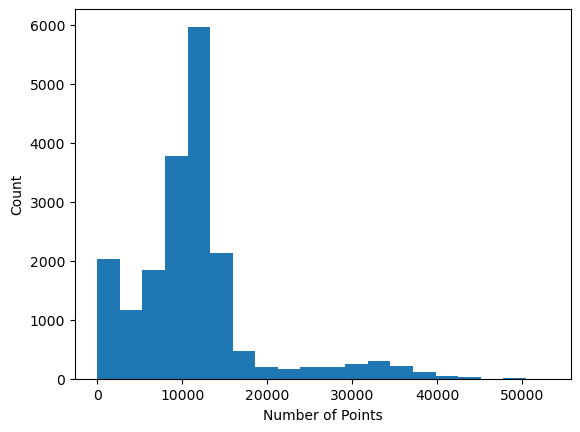

In [17]:
plt.hist(len_coords, bins=20)
plt.xlabel("Number of Points")
plt.ylabel("Count")
plt.show()

In [94]:
files = glob.glob(r"D:\MurrayBrent\data\RMF_ITD\plots\plot_laz\test\*.laz")

In [18]:
# list all valid lidar plots
files = list(Path("D:\MurrayBrent\data\RMF_ITD\plots\plot_laz").glob("*.laz"))

In [73]:
plots = gpd.read_file(r"D:\MurrayBrent\data\RMF_ITD\plots\plots.shp")

In [96]:
plots = gpd.read_file(r"D:\MurrayBrent\data\RMF_ITD\plots\plots_test.shp")

In [97]:
filenames = [os.path.basename(str(i))[:-4] for i in files]

In [98]:
plots_sub = plots[plots["POLYID"].isin(filenames)]

In [65]:
plots_sub, specs = get_perc_specs(plots_sub)

In [66]:
print(specs)
print(len(plots_sub))
plots_subset = plots_sub[specs]  # subset plots to only relevant columns
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

['BF', 'BW', 'CE', 'LA', 'PB', 'PT', 'PJ', 'PO', 'PW', 'SB', 'SX', 'SW']
5919
BF: 1185
BW: 2902
CE: 1271
LA: 1485
PB: 2
PT: 2162
PJ: 1075
PO: 222
PW: 11
SB: 5152
SX: 2
SW: 270


In [67]:
plots_rm = remove_plots(plots_sub, specs, n=100)

In [86]:
plots_sub, specs = get_perc_specs(plots_rm)

In [100]:
plots_sub, specs = get_perc_specs(plots_sub)

In [101]:
print(specs)
print(len(plots_sub))
plots_subset = plots_sub[specs]  # subset plots to only relevant columns
for column_name in plots_subset.columns:  # for each colum
    column = plots_subset[column_name]
    counts = column[column != 0].count()  # count non zero values
    print(f"{column_name}: {counts}")

['BF', 'BW', 'CE', 'LA', 'PT', 'PJ', 'PO', 'SB', 'SW']
2806
BF: 542
BW: 1392
CE: 590
LA: 688
PT: 1051
PJ: 523
PO: 109
SB: 2456
SW: 136


In [71]:
polyid = plots_sub["POLYID"].to_list()

In [72]:
l3 = [x for x in filenames if x not in polyid]

In [77]:
for i in l3:
    filepath = os.path.join(
        r"D:\MurrayBrent\data\RMF_ITD\plots\plot_laz\test", i + ".laz"
    )
    os.remove(filepath)

In [102]:
plots_sub.to_csv(r"D:\MurrayBrent\data\RMF_ITD\plots\plot_laz\plots_test.csv")
plots_sub = plots_sub.drop(["perc_specs"], axis=1)
plots_sub = gpd.GeoDataFrame(plots_sub, geometry="geometry")
plots_sub.to_file(r"D:\MurrayBrent\data\RMF_ITD\plots\plot_laz\plots_test.shp")

In [102]:
# list all valid lidar plots
files = list(Path("D:\MurrayBrent\data\RMF_ITD\plots\plot_laz").glob("*.laz"))

# move training files
random.seed(34)
num_train = round(len(files) * 0.8)
train_files = random.sample(files, num_train)
for file in tqdm(train_files):
    move_files(file, r"D:\MurrayBrent\data\RMF_ITD\plots\plot_laz\train")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 11215/11215 [00:39<00:00, 282.87it/s]


In [103]:
# list remaing files
files = list(Path("D:\MurrayBrent\data\RMF_ITD\plots\plot_laz").glob("*.laz"))

In [104]:
for file in tqdm(files):
    move_files(file, r"D:\MurrayBrent\data\RMF_ITD\plots\plot_laz\val")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 2804/2804 [00:10<00:00, 259.93it/s]


In [ ]:
## 

## comparison rmf vs ovf

### updyear

In [46]:
rmf_fri_clean = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_fri\RMF_PolygonForest_clean.shp"
)

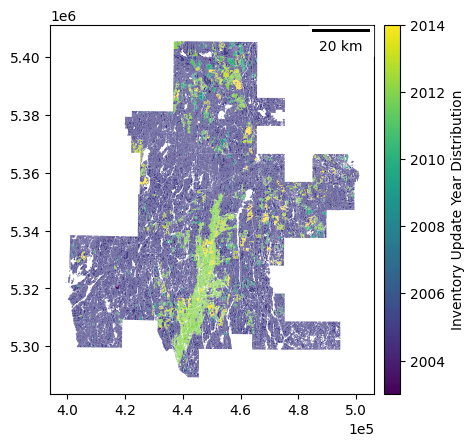

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots(1, 1)
ax.add_artist(ScaleBar(1))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

rmf_fri_clean.plot(
    column="YRUPD", 
    ax=ax,
    legend=True,
    cax=cax,
    legend_kwds={"label": "Inventory Update Year Distribution"},
)
plt.show()


In [48]:
fig.savefig(r"../../paper/RMF_YRUPD.svg", format="svg")

In [35]:
import numpy as np
gdf = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\ovf_fri\OVF_2021_PCI\ovf_fri_cleaned.shp"
)
if 'YRUPD' not in gdf.columns:  # check if field exists
    gdf['YRUPD'] = None  # initialize field
    gdf['YRUPD'] = gdf['YRUPD'].astype("string")

gdf['YRUPD'] = np.where(gdf['YRUPDATE'].notnull(), gdf['YRUPDATE'], gdf['YRSOURCE'])

gdf['YRUPD']

0        1990
1        1990
2        1990
3        1990
4        1990
         ... 
57095    2019
57096    2019
57097    2019
57098    2019
57099    2019
Name: YRUPD, Length: 57100, dtype: object

In [36]:
gdf['YRUPD'] = gdf['YRUPD'].astype(int)

<Axes: >

<Figure size 1200x800 with 0 Axes>

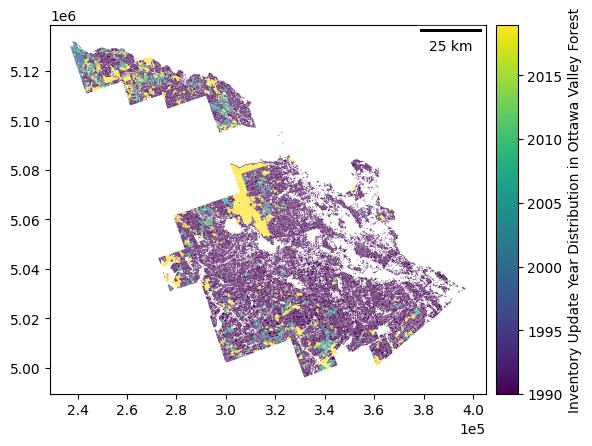

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib_scalebar.scalebar import ScaleBar

plt.figure(figsize=(12, 8))
fig, ax = plt.subplots(1, 1)
ax.add_artist(ScaleBar(1))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#ax.set_axis_off()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

gdf.plot(
    column="YRUPD", 
    ax=ax,
    legend=True,
    cax=cax,
    legend_kwds={"label": "Inventory Update Year Distribution in Ottawa Valley Forest"},
)

In [45]:
fig.savefig(r"../../paper/ovf_YRUPD.svg", format="svg")

### dominant species

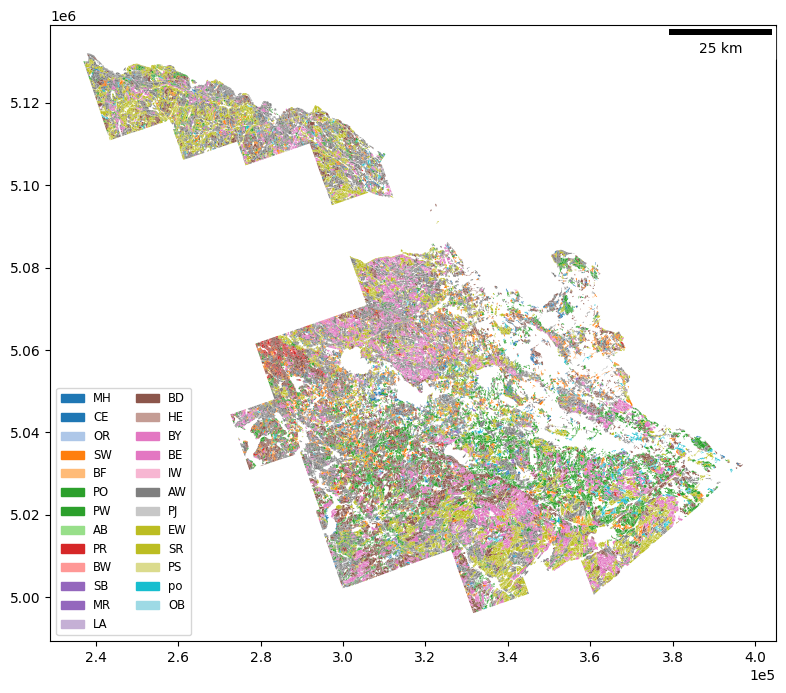

In [88]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
# Add a scale bar
ax.add_artist(ScaleBar(1))

# Use scientific notation for x-axis labels
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Plot the GeoDataFrame
gdf.plot(
    column="OLEADSPC", 
    ax=ax,
    legend=False  # Disable the default legend
)

# Get the unique species from the GeoDataFrame and their corresponding colors
unique_species = gdf["OLEADSPC"].unique()
colors = [plt.colormaps['tab20'](i / len(unique_species)) for i in range(len(unique_species))]

# Add patches to represent each species in the legend
patches = [mpatches.Patch(color=colors[i], label=unique_species[i]) for i in range(len(unique_species))]

# Add a custom legend
ax.legend(
    handles=patches, 
    ncol=2,  # Number of columns in the legend (adjust as needed)
    loc='lower left',  # Position the legend at the bottom center
    bbox_to_anchor=(0, 0),  # Adjust the anchor to place it outside the plot
    fontsize='small'
)

plt.show()

In [89]:
fig.savefig(r"../../paper/ovf_OLEADSPC.svg", format="svg")

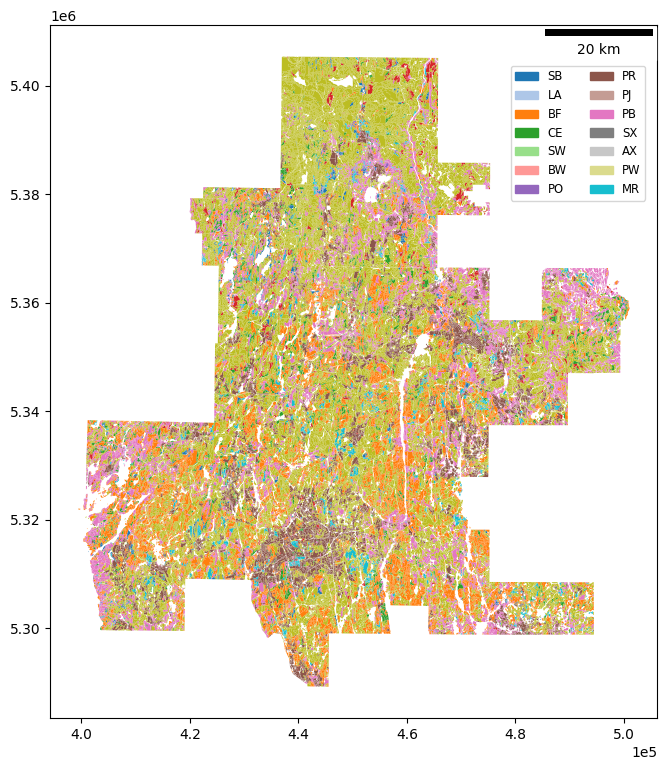

In [101]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
# Add a scale bar
ax.add_artist(ScaleBar(1))

# Use scientific notation for x-axis labels
ax.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Plot the GeoDataFrame
rmf_fri_clean.plot(
    column="WG", 
    ax=ax,
    legend=False  # Disable the default legend
)

# Get the unique species from the GeoDataFrame and their corresponding colors
unique_species = rmf_fri_clean["WG"].unique()
colors = [plt.colormaps['tab20'](i / len(unique_species)) for i in range(len(unique_species))]

# Add patches to represent each species in the legend
patches = [mpatches.Patch(color=colors[i], label=unique_species[i]) for i in range(len(unique_species))]

# Add a custom legend
ax.legend(
    handles=patches, 
    ncol=2,  # Number of columns in the legend (adjust as needed)
    loc='upper right',  # Position the legend at the bottom center
    bbox_to_anchor=(0.99, 0.95),  # Adjust the anchor to place it outside the plot
    fontsize='small'
)

plt.show()

In [102]:
fig.savefig(r"../../paper/rmf_OLEADSPC.svg", format="svg")

In [110]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

C:\Users\ycao68\AppData\Local\Temp\ipykernel_19444\2459411131.py:33: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf1.plot(
C:\Users\ycao68\AppData\Local\Temp\ipykernel_19444\2459411131.py:43: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf2.plot(


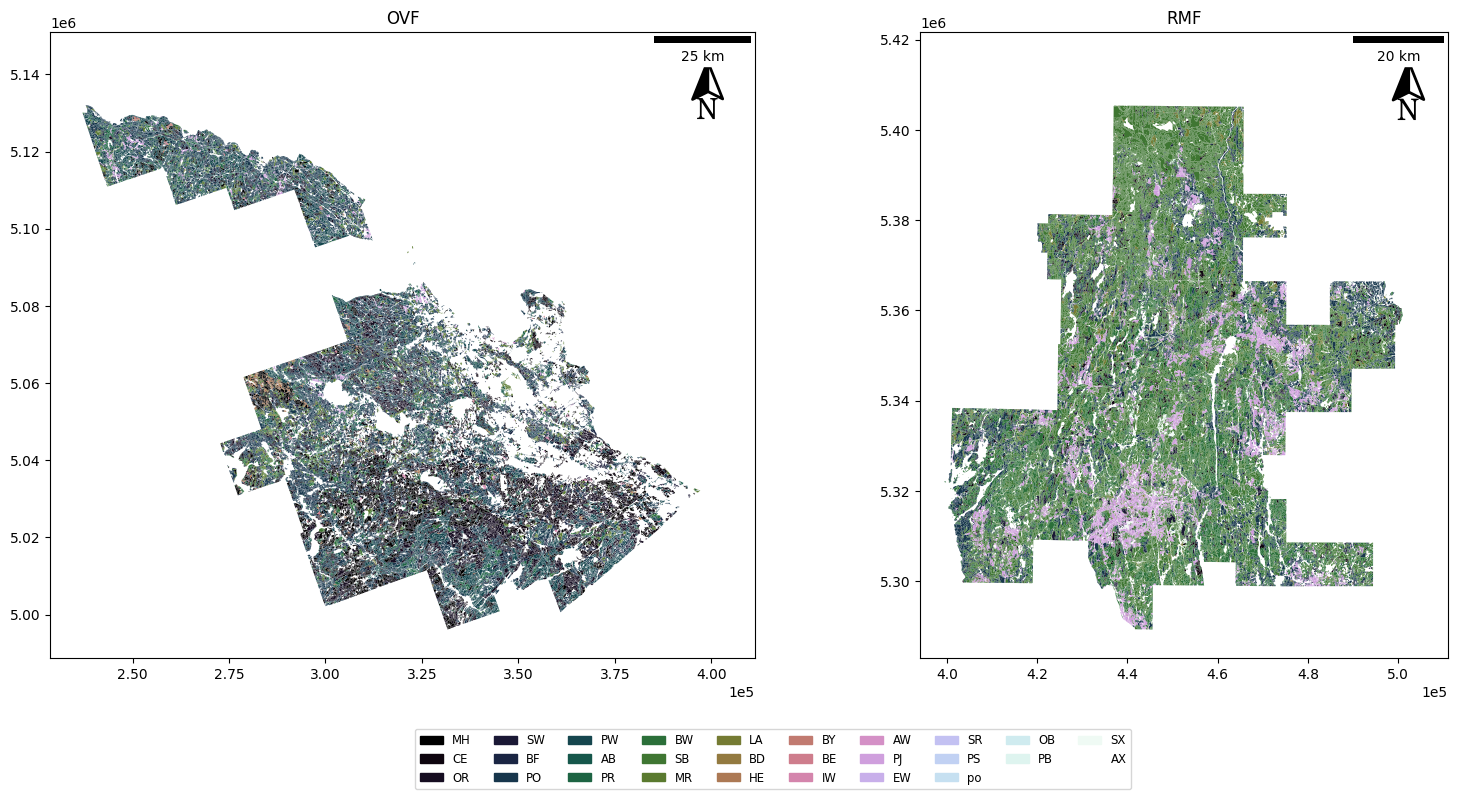

In [177]:
# !pip install git+https://github.com/pmdscully/geo_northarrow.git
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from geo_northarrow import add_north_arrow
#from cmcrameri import cm

gdf1 = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\ovf_fri\OVF_2021_PCI\ovf_fri_cleaned.shp"
)
gdf2 = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_fri\RMF_PolygonForest_clean.shp"
)

# Concatenate unique species from both GeoDataFrames
unique_species = pd.concat([gdf1["OLEADSPC"], gdf2["WG"]]).unique()

# Create a color map for all species
# or check cmcrameri for more cmaps
colors = [discrete_cmap(len(unique_species), 'cubehelix')(i / len(unique_species)) for i in range(len(unique_species))]
color_map = dict(zip(unique_species, colors))

# Create a figure with two subplots (axes)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# Add a scale bar
ax1.add_artist(ScaleBar(1))
ax2.add_artist(ScaleBar(1))
# Use scientific notation for x-axis labels
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Plot the first GeoDataFrame on the first axis
gdf1.plot(
    column="OLEADSPC", 
    ax=ax1,
    color=gdf1["OLEADSPC"].map(color_map),  # Map colors to species
    legend=False
)

ax1.set_title("OVF")

# Plot the second GeoDataFrame on the second axis
gdf2.plot(
    column="WG", 
    ax=ax2,
    color=gdf2["WG"].map(color_map),  # Map colors to species
    legend=False
)

ax2.set_title("RMF")

# Add patches to represent each species in the legend
patches = [mpatches.Patch(color=colors[i], label=unique_species[i]) for i in range(len(unique_species))]

# Add a custom legend
fig.legend(
    handles=patches, 
    ncol=10,  # Number of columns in the legend
    loc='lower center',  # Position the legend at the bottom center
    bbox_to_anchor=(0.5, 0),  # Adjust the anchor to place it below the subplots
    fontsize='small'
)
# Add north arrow
add_north_arrow(ax1, scale=.55, xlim_pos=.965, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
add_north_arrow(ax2, scale=.65, xlim_pos=.965, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit legend below the plots
plt.show()

In [178]:
fig.savefig(r"../../paper/compare_leadspec_rmf_ovf.svg", format="svg")

### common species after clean in test data

C:\Users\ycao68\AppData\Local\Temp\ipykernel_19444\3066373447.py:32: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf1.plot(
C:\Users\ycao68\AppData\Local\Temp\ipykernel_19444\3066373447.py:42: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf2.plot(


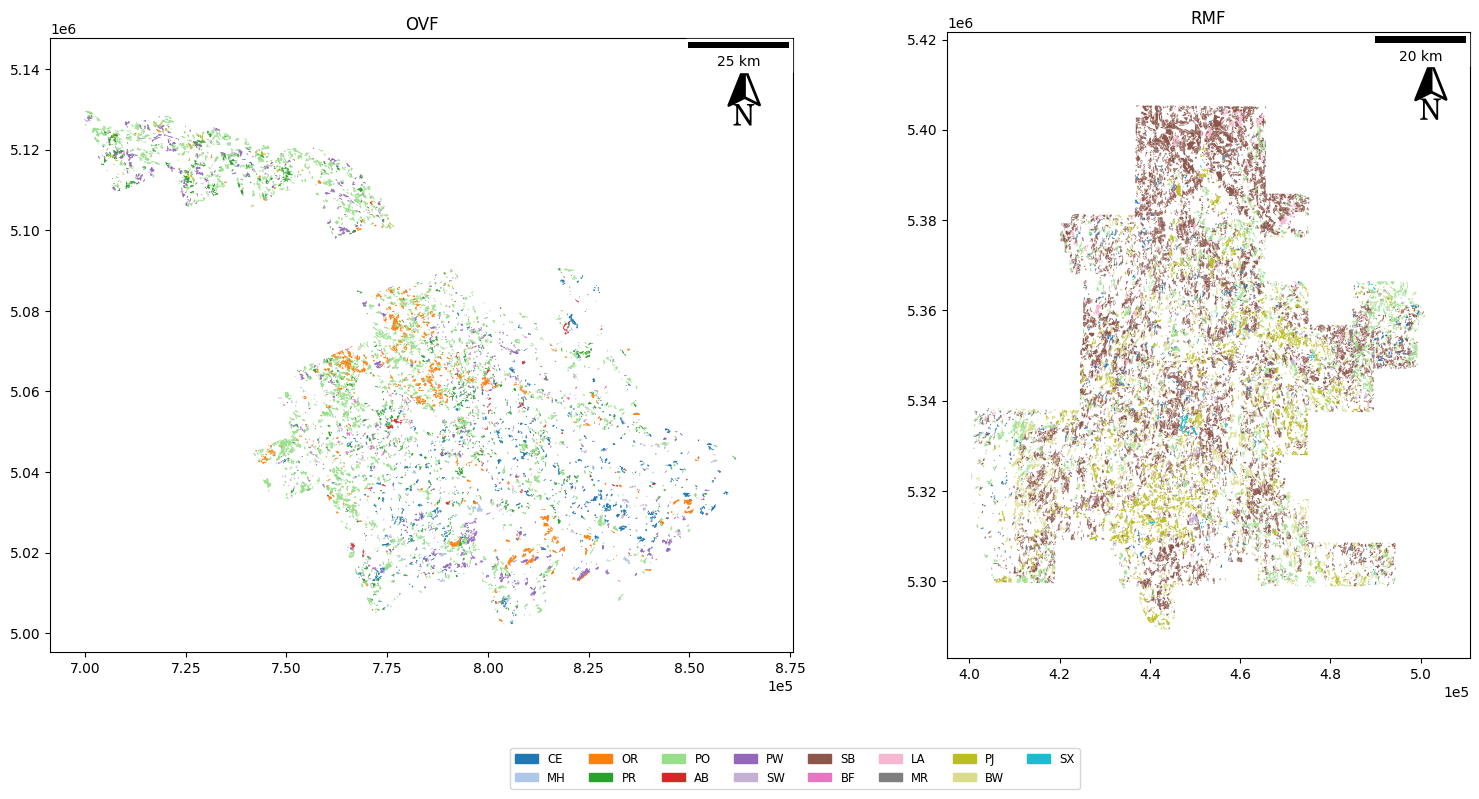

In [175]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from geo_northarrow import add_north_arrow
#from cmcrameri import cm

gdf1 = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\ovf_fri\OVF_2021_PCI\ovf_fri_cleaned_containplots.shp"
)
gdf2 = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_fri\RMF_PolygonForest_cleaned_containplots.shp"
)

# Concatenate unique species from both GeoDataFrames
unique_species = pd.concat([gdf1["OLEADSPC"], gdf2["WG"]]).unique()

# Create a color map for all species
# or check cmcrameri for more cmaps
colors = [plt.colormaps["tab20"](i / len(unique_species)) for i in range(len(unique_species))]
color_map = dict(zip(unique_species, colors))

# Create a figure with two subplots (axes)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# Add a scale bar
ax1.add_artist(ScaleBar(1))
ax2.add_artist(ScaleBar(1))
# Use scientific notation for x-axis labels
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Plot the first GeoDataFrame on the first axis
gdf1.plot(
    column="OLEADSPC", 
    ax=ax1,
    color=gdf1["OLEADSPC"].map(color_map),  # Map colors to species
    legend=False
)

ax1.set_title("OVF")

# Plot the second GeoDataFrame on the second axis
gdf2.plot(
    column="WG", 
    ax=ax2,
    color=gdf2["WG"].map(color_map),  # Map colors to species
    legend=False
)

ax2.set_title("RMF")

# Add patches to represent each species in the legend
patches = [mpatches.Patch(color=colors[i], label=unique_species[i]) for i in range(len(unique_species))]

# Add a custom legend
fig.legend(
    handles=patches, 
    ncol=8,  # Number of columns in the legend
    loc='lower center',  # Position the legend at the bottom center
    bbox_to_anchor=(0.5, 0.00),  # Adjust the anchor to place it below the subplots
    fontsize='small'
)
# Add north arrow
add_north_arrow(ax1, scale=.55, xlim_pos=.965, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)
add_north_arrow(ax2, scale=.65, xlim_pos=.965, ylim_pos=.965, color='#000', text_scaler=4, text_yT=-1.25)

plt.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to fit legend below the plots
plt.show()

In [176]:
fig.savefig(r"../../paper/compare_plotcommspec_rmf_ovf.svg", format="svg")

C:\Users\ycao68\AppData\Local\Temp\ipykernel_19444\2852245117.py:27: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf2.plot(


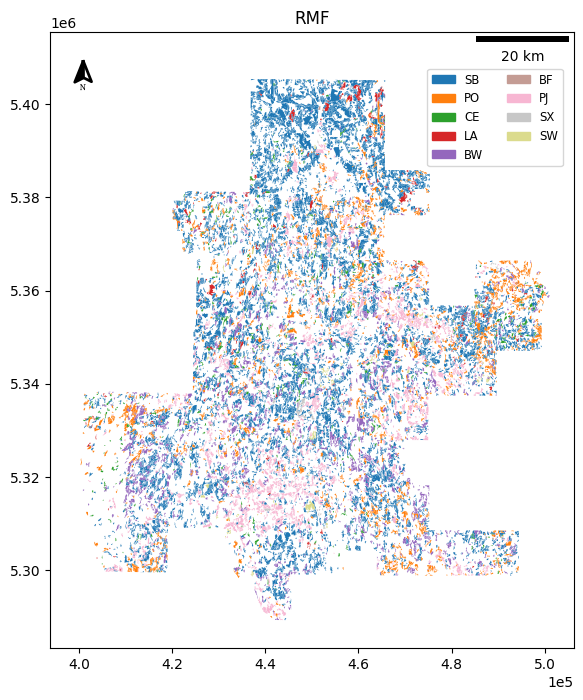

In [160]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from geo_northarrow import add_north_arrow
#from cmcrameri import cm

gdf2 = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\rmf\rmf_fri\RMF_PolygonForest_cleaned_containplots.shp"
)

# Concatenate unique species from both GeoDataFrames
unique_species = gdf2["WG"].unique()

# Create a color map for all species
# or check cmcrameri for more cmaps
colors = [plt.colormaps["tab20"](i / len(unique_species)) for i in range(len(unique_species))]
color_map = dict(zip(unique_species, colors))

# Create a figure with two subplots (axes)
fig, ax2 = plt.subplots(1, 1, figsize=(8, 8))
# Add a scale bar
ax2.add_artist(ScaleBar(1))
# Use scientific notation for x-axis labels
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Plot the second GeoDataFrame on the second axis
gdf2.plot(
    column="WG", 
    ax=ax2,
    color=gdf2["WG"].map(color_map),  # Map colors to species
    legend=False
)

ax2.set_title("RMF")

# Add patches to represent each species in the legend
patches = [mpatches.Patch(color=colors[i], label=unique_species[i]) for i in range(len(unique_species))]

# Add a custom legend
ax2.legend(
    handles=patches, 
    ncol=2,  # Number of columns in the legend (adjust as needed)
    loc='upper right',  # Position the legend at the bottom center
    bbox_to_anchor=(0.99, 0.95),  # Adjust the anchor to place it outside the plot
    fontsize='small'
)
# Add north arrow
add_north_arrow(ax2, scale=.35, xlim_pos=.05, ylim_pos=.95, color='#000', text_scaler=2, text_yT=-1.25)

plt.show()

In [161]:
fig.savefig(r"../../paper/plotcommspec_rmf.svg", format="svg")

C:\Users\ycao68\AppData\Local\Temp\ipykernel_19444\531419409.py:27: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf2.plot(


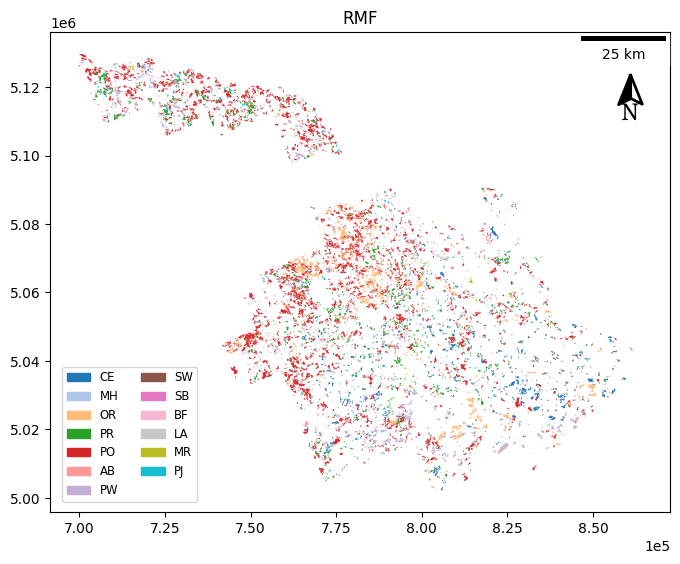

In [171]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
from geo_northarrow import add_north_arrow
#from cmcrameri import cm

gdf2 = gpd.read_file(
    r"D:\Sync\research\tree species estimation\tree dataset\ovf\ovf_fri\OVF_2021_PCI\ovf_fri_cleaned_containplots.shp"
)

# Concatenate unique species from both GeoDataFrames
unique_species = gdf2["OLEADSPC"].unique()

# Create a color map for all species
# or check cmcrameri for more cmaps
colors = [plt.colormaps["tab20"](i / len(unique_species)) for i in range(len(unique_species))]
color_map = dict(zip(unique_species, colors))

# Create a figure with two subplots (axes)
fig, ax2 = plt.subplots(1, 1, figsize=(8, 8))
# Add a scale bar
ax2.add_artist(ScaleBar(1))
# Use scientific notation for x-axis labels
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Plot the second GeoDataFrame on the second axis
gdf2.plot(
    column="OLEADSPC", 
    ax=ax2,
    color=gdf2["OLEADSPC"].map(color_map),  # Map colors to species
    legend=False
)

ax2.set_title("RMF")

# Add patches to represent each species in the legend
patches = [mpatches.Patch(color=colors[i], label=unique_species[i]) for i in range(len(unique_species))]

# Add a custom legend
ax2.legend(
    handles=patches, 
    ncol=2,  # Number of columns in the legend (adjust as needed)
    loc='lower left',  # Position the legend at the bottom center
    bbox_to_anchor=(0.01, 0.01),  # Adjust the anchor to place it outside the plot
    fontsize='small'
)
# Add north arrow
add_north_arrow(ax2, scale=.5, xlim_pos=.95, ylim_pos=.85, color='#000', text_scaler=4, text_yT=-1.25)

plt.show()

In [172]:
fig.savefig(r"../../paper/plotcommspec_ovf.svg", format="svg")